<a href="https://colab.research.google.com/github/MHusni1604/KKN-Periode-2/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===📦 Paket bawaan===
import os
import random
import shutil

# ===📊 Data dan visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan gambar===
from PIL import Image
import cv2

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras import Input
from keras.layers import TFSMLayer

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split

# ===🌐 Kaggle Hub===
import kagglehub

In [2]:
path_1 = kagglehub.dataset_download("huberthamelin/garbage-classification-labels-corrections")
path_2 = kagglehub.dataset_download("namanjain001/comprehensive-solid-waste-image-dataset")
path_3 = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path_1)
print("Path to dataset files:", path_2)
print("Path to dataset files:", path_3)

100%|██████████| 497M/497M [00:06<00:00, 77.8MB/s]

Extracting files...


100%|██████████| 2.29G/2.29G [00:28<00:00, 85.6MB/s]

Extracting files...


100%|██████████| 744M/744M [00:09<00:00, 86.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4
Path to dataset files: /root/.cache/kagglehub/datasets/namanjain001/comprehensive-solid-waste-image-dataset/versions/1
Path to dataset files: /root/.cache/kagglehub/datasets/sumn2u/garbage-classification-v2/versions/8


In [3]:
print(os.listdir(path_1))
print(os.listdir(path_2))
print(os.listdir(path_3))

['labels_corrections.csv', 'garbage_classification_enhanced', 'garbage_classification_corrected']
['Solid_Waste_Dataset']
['garbage-dataset']


In [4]:
print("path 1 class:", os.listdir(os.path.join(path_1, 'garbage_classification_enhanced')))
print("path 2 class:", os.listdir(os.path.join(path_2, 'Solid_Waste_Dataset')))
print("path 3 class:", os.listdir(os.path.join(path_3, 'garbage-dataset')))

path 1 class: ['white-glass', 'battery', 'trash', 'green-glass', 'paper', 'cardboard', 'biological', 'shoes', 'clothes', 'metal', 'brown-glass', 'plastic']
path 2 class: ['Medical_Waste', 'Construction_Waste', 'Organic_Waste', 'Plastic_Waste', 'Textile_Rubber_Waste', 'Glass_Waste', 'Metal_Waste', 'Paper_Cardboard_Waste', 'Electronic_Waste']
path 3 class: ['battery', 'glass', 'trash', 'paper', 'cardboard', 'biological', 'shoes', 'clothes', 'metal', 'plastic']


In [5]:
folder_1 = os.path.join(path_1, 'garbage_classification_enhanced')
folder_2 = os.path.join(path_2, 'Solid_Waste_Dataset')
folder_3 = os.path.join(path_3, 'garbage-dataset')

class_names_1 = os.listdir(folder_1)
class_names_2 = os.listdir(folder_2)
class_names_3 = os.listdir(folder_3)

print("Class names in folder 1:", class_names_1)
print("Class names in folder 2:", class_names_2)
print("Class names in folder 3:", class_names_3)

Class names in folder 1: ['white-glass', 'battery', 'trash', 'green-glass', 'paper', 'cardboard', 'biological', 'shoes', 'clothes', 'metal', 'brown-glass', 'plastic']
Class names in folder 2: ['Medical_Waste', 'Construction_Waste', 'Organic_Waste', 'Plastic_Waste', 'Textile_Rubber_Waste', 'Glass_Waste', 'Metal_Waste', 'Paper_Cardboard_Waste', 'Electronic_Waste']
Class names in folder 3: ['battery', 'glass', 'trash', 'paper', 'cardboard', 'biological', 'shoes', 'clothes', 'metal', 'plastic']


In [6]:
from collections import defaultdict


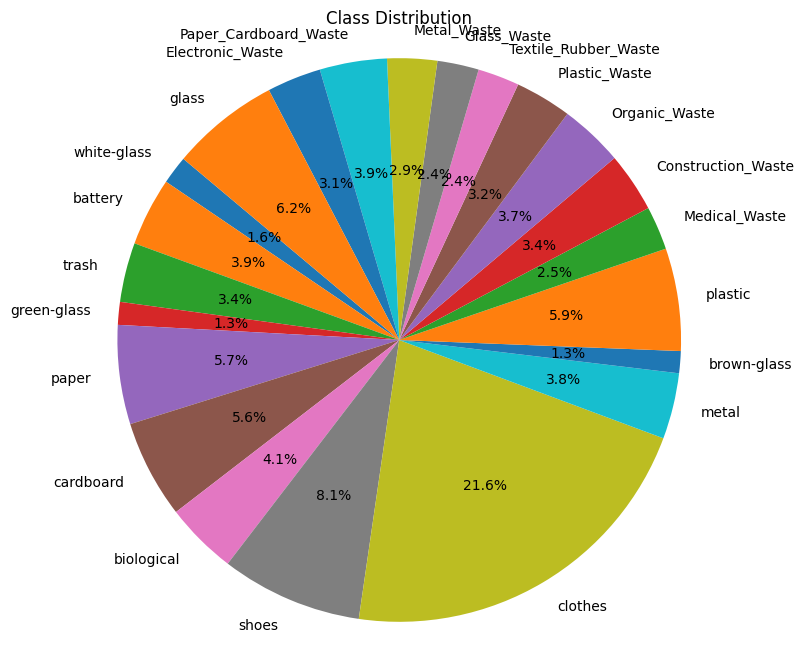

In [7]:
# Hitung jumlah gambar per kelas dari kedua folder
class_counts_dict = defaultdict(int)
for folder in [folder_1, folder_2, folder_3]:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            class_counts_dict[class_name] += len(os.listdir(class_path))

# Pisahkan nama kelas dan jumlahnya
class_names = list(class_counts_dict.keys())
class_counts = list(class_counts_dict.values())

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Untuk memastikan pie berbentuk bulat
plt.show()

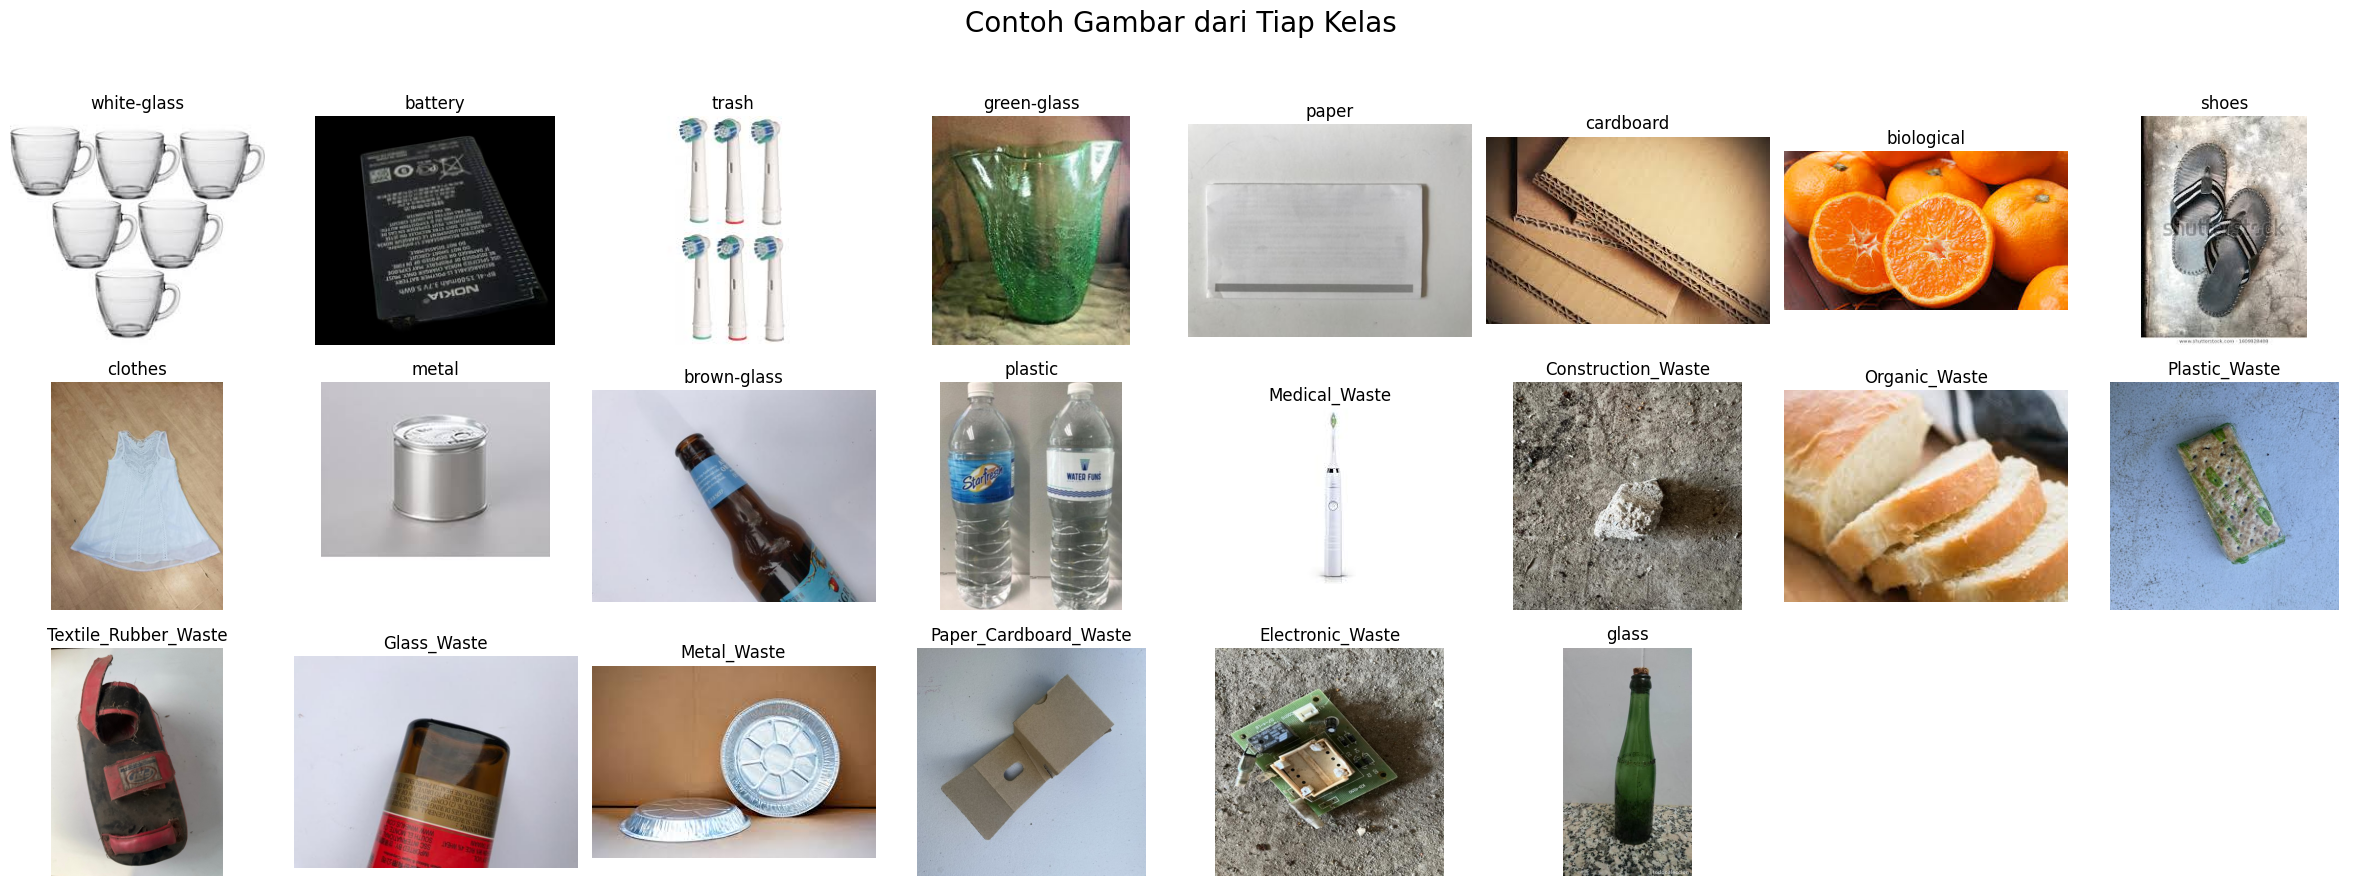

In [8]:
# Pastikan folder_1 dan folder_2 sudah didefinisikan
folders = [folder_1, folder_2, folder_3]

n_classes = len(class_names)
n_rows = 3
n_cols = int(np.ceil(n_classes / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()  # ubah ke 1D array supaya mudah di-loop

for i, class_name in enumerate(class_names):
    ax = axs[i]
    image_paths = []

    # Gabungkan semua gambar dari folder_1 dan folder_2
    for folder in folders:
        path = os.path.join(folder, class_name)
        if os.path.exists(path):
            image_paths += [os.path.join(path, img) for img in os.listdir(path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if image_paths:
        img_path = random.choice(image_paths)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(class_name)
    else:
        ax.set_title(f"{class_name}\n(no image)")

    ax.axis('off')

# Sembunyikan subplot kosong jika jumlah kelas lebih sedikit dari subplot
for j in range(len(class_names), len(axs)):
    axs[j].axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # beri ruang untuk judul
plt.show()

In [9]:
label_to_category = {
    # Limbah B3
    'battery': 'b3',
    'Medical_Waste': 'b3',
    'Electronic_Waste': 'b3',

    # Organik
    'biological': 'organik',
    'Organic_Waste': 'organik',

    # Daur Ulang
    'paper': 'daur_ulang',
    'cardboard': 'daur_ulang',
    'Paper_Cardboard_Waste': 'daur_ulang',
    'plastic': 'daur_ulang',
    'Plastic_Waste': 'daur_ulang',
    'metal': 'daur_ulang',
    'Metal_Waste': 'daur_ulang',
    'glass': 'daur_ulang',
    'white-glass': 'daur_ulang',
    'green-glass': 'daur_ulang',
    'brown-glass': 'daur_ulang',
    'Glass_Waste': 'daur_ulang',

    # Residu
    'trash': 'residu',
    'Construction_Waste': 'residu',
    'Textile_Rubber_Waste': 'residu',
    'shoes': 'residu',   # diasumsikan sintetis
    'clothes': 'residu'  # diasumsikan sintetis
}


In [10]:
source_folders = [folder_1, folder_2, folder_3]
target_root = 'dataset_kategori'
os.makedirs(target_root, exist_ok=True)

# Buat folder kategori jika belum ada
for new_class in set(label_to_category.values()):
    os.makedirs(os.path.join(target_root, new_class), exist_ok=True)

# Proses semua gambar dari kedua folder
for source_root in source_folders:
    for old_class, new_class in label_to_category.items():
        old_path = os.path.join(source_root, old_class)
        new_path = os.path.join(target_root, new_class)

        if not os.path.exists(old_path):
            print(f"⚠️ Folder tidak ditemukan: {old_path}")
            continue

        for file in os.listdir(old_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(old_path, file)
                # Tambahkan nama folder asal sebagai prefix agar unik
                prefix = os.path.basename(source_root)
                dst = os.path.join(new_path, f"{prefix}_{old_class}_{file}")
                shutil.copy(src, dst)

⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/garbage_classification_enhanced/Medical_Waste
⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/garbage_classification_enhanced/Electronic_Waste
⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/garbage_classification_enhanced/Organic_Waste
⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/garbage_classification_enhanced/Paper_Cardboard_Waste
⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/garbage_classification_enhanced/Plastic_Waste
⚠️ Folder tidak ditemukan: /root/.cache/kagglehub/datasets/huberthamelin/garbage-classification-labels-corrections/versions/4/gar

In [11]:
new_class = os.listdir(os.path.join('dataset_kategori'))
print(new_class)

['organik', 'residu', 'b3', 'daur_ulang']


In [12]:
# Konfigurasi
source_dir = 'dataset_kategori'
target_dir = 'dataset_split'
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Buat folder tujuan
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

# Bagi gambar
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n = len(images)
    n_train = int(n * split_ratio['train'])
    n_val = int(n * split_ratio['val'])

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(target_dir, split, class_name, file)
            shutil.copy(src, dst)

print("✅ Dataset berhasil dibagi menjadi train, val, dan test.")

✅ Dataset berhasil dibagi menjadi train, val, dan test.


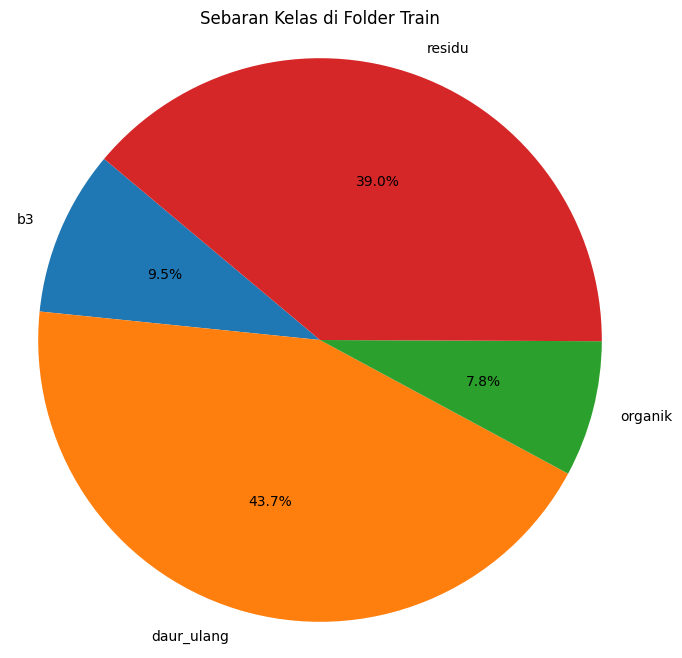

In [13]:
train_dir = 'dataset_split/train'

class_names = sorted(os.listdir(train_dir))  # nama folder kelas
class_counts = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(count)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Sebaran Kelas di Folder Train')
plt.axis('equal')
plt.show()

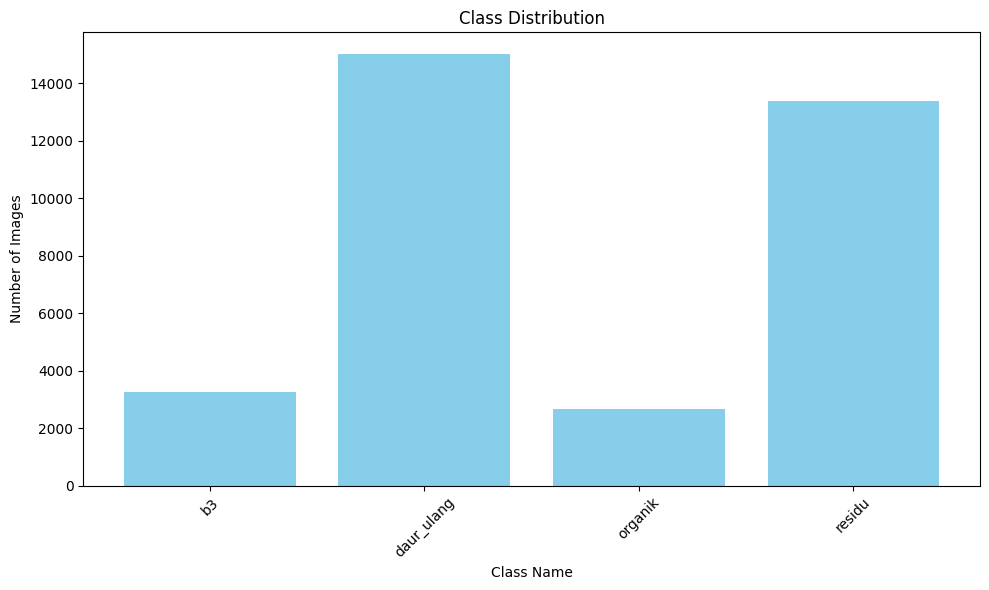

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Path ke data latih setelah split
train_dir = os.path.join(target_dir, 'train')

# Dapatkan jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Cari jumlah gambar minimum (kelas minoritas)
min_count = min(class_counts.values())

# Lakukan under sampling: kurangi jumlah gambar kelas mayoritas
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if len(images) > min_count:
        # Acak dan ambil sejumlah min_count gambar
        random.shuffle(images)
        images_to_keep = images[:min_count]
        images_to_remove = set(images) - set(images_to_keep)

        # Hapus gambar yang tidak termasuk yang akan disimpan
        for img in images_to_remove:
            os.remove(os.path.join(class_path, img))

print("✅ Under sampling selesai pada data latih.")

✅ Under sampling selesai pada data latih.


In [16]:
train_dir = '/content/dataset_split/train'

class_counts = {}
total_count = 0

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = count
        total_count += count

# Tampilkan hasil
print("📊 Jumlah gambar per kelas di TRAIN:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} gambar")

print(f"\n🧮 Total gambar di set TRAIN: {total_count} gambar")

📊 Jumlah gambar per kelas di TRAIN:
  b3: 2677 gambar
  daur_ulang: 2677 gambar
  organik: 2677 gambar
  residu: 2677 gambar

🧮 Total gambar di set TRAIN: 10708 gambar


In [17]:
base_dir = 'dataset_split'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 10708 images belonging to 4 classes.
Found 7363 images belonging to 4 classes.
Found 7357 images belonging to 4 classes.


In [18]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Ambil label kelas dari train generator
# class_indices = train_gen.class_indices
# class_labels = list(class_indices.keys())

# # Ambil label aktual (dalam bentuk angka)
# y_train = train_gen.classes

# # Hitung class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# # Bentuk dalam format dictionary
# class_weights = dict(zip(np.unique(y_train), class_weights))
# print("Class Weights:", class_weights)

In [19]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [20]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Gunakan ukuran input sesuai DenseNet121 (minimal 150x150)
input_shape = (150, 150, 3)

# Load model DenseNet121 tanpa top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Bekukan layer awal dulu untuk transfer learning

# Tambahkan classification head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        65,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,103,044 (27.10 MB)

 Trainable params: 65,540 (256.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [21]:
callback = [
    StopTrainingAtAccuracy(),
    ModelCheckpoint('model_checkpoint.keras', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callback,
    # class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7542 - loss: 1.1105
Epoch 1: val_loss improved from inf to 0.75947, saving model to model_checkpoint.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 1405s 4s/step - accuracy: 0.7543 - loss: 1.1102 - val_accuracy: 0.8711 - val_loss: 0.7595
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8240 - loss: 0.9701
Epoch 2: val_loss did not improve from 0.75947
335/335 ━━━━━━━━━━━━━━━━━━━━ 1386s 4s/step - accuracy: 0.8240 - loss: 0.9700 - val_accuracy: 0.8404 - val_loss: 1.0781
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8475 - loss: 0.9241
Epoch 3: val_loss did not improve from 0.75947
335/335 ━━━━━━━━━━━━━━━━━━━━ 1328s 4s/step - accuracy: 0.8475 - loss: 0.9243 - val_accuracy: 0.8429 - val_loss: 1.2638
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8424 - loss: 1.0213
Epoch 4: val_loss did not improve from 0.75947
335/335 ━━━━━━━━━━━━━━━━━━━━ 1312s 4s/step - accuracy: 0.8424 - loss: 1.021

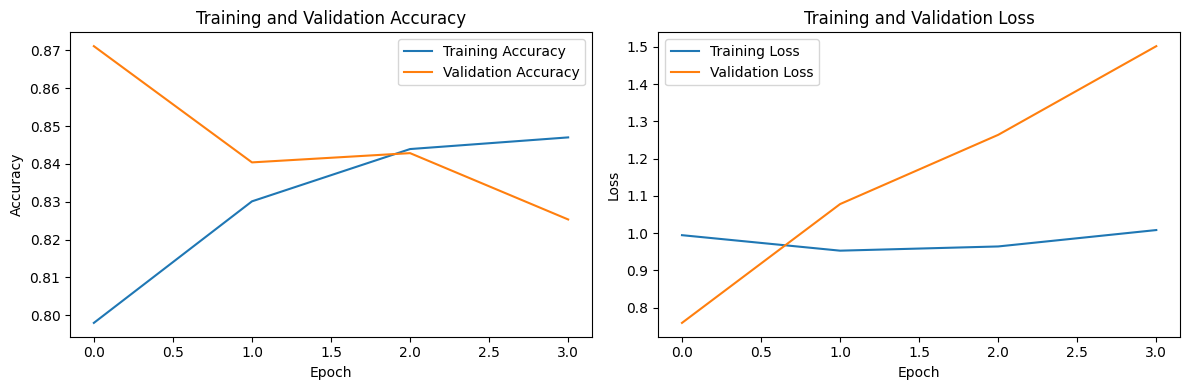

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

231/231 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.8279 - loss: 1.4411
Test Loss: 1.5253, Test Accuracy: 0.8229


In [34]:
from sklearn.metrics import classification_report
import numpy as np

# Langkah 1: Dapatkan ground truth dan prediksi dari val/test generator
# Misal pakai test_gen
test_gen.reset()
pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Langkah 2: Ambil nama kelas
class_labels = list(test_gen.class_indices.keys())

# Langkah 3: Cetak classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

231/231 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step
              precision    recall  f1-score   support

          b3       0.11      0.25      0.15       699
  daur_ulang       0.44      0.38      0.41      3221
     organik       0.09      0.10      0.09       575
      residu       0.40      0.32      0.36      2868

    accuracy                           0.32      7363
   macro avg       0.26      0.26      0.25      7363
weighted avg       0.37      0.32      0.34      7363



In [25]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [26]:
model.save("/content/my_model.keras")

In [35]:
model.save("/content/my_model.h5")

In [28]:
!tensorflowjs_converter \
    --input_format=keras \
    my_model.h5 \
    tfjs_model/

2025-07-03 08:15:23.148904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751530523.177698   27827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751530523.186850   27827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [29]:
from google.colab import files

!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of7.bin (deflated 7%)
  adding: tfjs_model/group1-shard7of7.bin (deflated 6%)
  adding: tfjs_model/group1-shard2of7.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of7.bin (deflated 7%)
  adding: tfjs_model/group1-shard5of7.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard6of7.bin (deflated 6%)
  adding: tfjs_model/group1-shard1of7.bin (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# SavedModel (untuk TFLite & TFJS)
model.export('/content//saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content//saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_427')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132438274795152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274793040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274798608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274795536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274795728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274796688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274798032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274795344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438274794384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132438286470608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13243

In [31]:
!zip -r saved_model.zip saved_model
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 79%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>